Imports and dataset loading

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

dataset_path = '../data/raw/default_of_credit_card_clients.xls'
data = pd.read_excel(dataset_path, header=1)

## 1. Dataset Exploration


### 1.1 Description

**Dataset** 

The dataset contains information on credit card clients in Taiwan from 2005. Each row represents a client, and the columns include demographic, financial, and payment history variables. The main goal is to predict whether a client will default on their credit card payment in the next month. 

**Dataset Source** - 

 **Original dataset size:** 30,000 rows (clients), 25 columns (features)

**Variable meanings**

- **ID**: Unique identifier for each client.
- **LIMIT_BAL**: Amount of given credit (NT dollar).
- **SEX**: Gender (1 = male, 2 = female; mapped to labels).
- **EDUCATION**: Education level (1 = graduate school, 2 = university, 3 = high school, 4 = others; 0, 5, 6 treated as unknown).
- **MARRIAGE**: Marital status (1 = married, 2 = single, 3 = divorce; 0 = unknown).
- **AGE**: Age in years.
- **PAY_0 to PAY_6**: Repayment status for the past 7 months (September to April;-2 = no consumption, -1 = pay duly, 1 = payment delay for one month, etc.).
- **BILL_AMT1 to BILL_AMT6**: Amount of bill statement (NT dollar) for each month (April to September).
- **PAY_AMT1 to PAY_AMT6**: Amount paid in the previous month (NT dollar) for each month (April to September).
- **default payment next month**: Target variable (1 = default, 0 = not default).

**Problem Statement:** 

In [82]:
data.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


### 1.2. Defining data types

- The dataset is being loaded from the Excel file (`default_of_credit_card_clients.xls`) into a pandas DataFrame.
- Lists of categorical and numerical features, as well as the target variable, are being defined.
- Specified columns are being converted to categorical data types for proper analysis.
- The `ID` column is being converted to string type.
- The `SEX` column is being mapped from numeric codes to string labels ('male', 'female').
- The `EDUCATION` column is being mapped from numeric codes to descriptive labels, with unknown or invalid codes (0, 5, 6) being set to NaN.
- The `MARRIAGE` column is being mapped from numeric codes to descriptive labels, with unknown codes (0) being set to NaN.
- A specific order is being set for the categories in the `EDUCATION` and `MARRIAGE` columns.
- The data types of all columns are being printed and DataFrame info is being displayed for verification.

In [47]:

#Rename PAY_0 to PAY_1 column for consistency
data.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)


# Convert specific columns to categorical types
categorical_features = [
    'SEX', 'EDUCATION', 'MARRIAGE',
    'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'default payment next month'
]

numerical_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                     'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

target = 'default payment next month'

for col in categorical_features:
    data[col] = data[col].astype('category')
data['ID'] = data['ID'].astype(str)

# Map categorical codes to labels and replace unknown values with nan
data['SEX'] = data['SEX'].map({1: 'male', 2: 'female'}).astype('category')

data['EDUCATION'] = data['EDUCATION'].map({
    1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others',
    5: np.nan, 6: np.nan, 0: np.nan
}).astype('category')

data['MARRIAGE'] = data['MARRIAGE'].map({
    1: 'married', 2: 'single', 3: 'divorce',
    0: np.nan
}).astype('category')

# Set a specific order for categorical variables
education_order = ['high school','university', 'graduate school', 'others']
data['EDUCATION'] = data['EDUCATION'].cat.reorder_categories(education_order, ordered=True)

# For MARRIAGE
marriage_order = ['single', 'married', 'divorce']
data['MARRIAGE'] = data['MARRIAGE'].cat.reorder_categories(marriage_order, ordered=True)


print("Types: ", data.dtypes)
print("Info: ", data.info())
print("Unique values in categorical features: ", data[categorical_features].nunique())

Types:  ID                              object
LIMIT_BAL                        int64
SEX                           category
EDUCATION                     category
MARRIAGE                      category
AGE                              int64
PAY_1                         category
PAY_2                         category
PAY_3                         category
PAY_4                         category
PAY_5                         category
PAY_6                         category
BILL_AMT1                        int64
BILL_AMT2                        int64
BILL_AMT3                        int64
BILL_AMT4                        int64
BILL_AMT5                        int64
BILL_AMT6                        int64
PAY_AMT1                         int64
PAY_AMT2                         int64
PAY_AMT3                         int64
PAY_AMT4                         int64
PAY_AMT5                         int64
PAY_AMT6                         int64
default payment next month    category
dtype: object
<cl

### 1.3. Check for missing values

After mapping some of the categories from EDUCATION and MARRIAGE to NA, we end up with a total of 399 missing values.
Given the size of the dataset, I simply removed them.

In [48]:
# Check for missing values and unique values
print("Missing values: ", data.isnull().sum())

Missing values:  ID                              0
LIMIT_BAL                       0
SEX                             0
EDUCATION                     345
MARRIAGE                       54
AGE                             0
PAY_1                           0
PAY_2                           0
PAY_3                           0
PAY_4                           0
PAY_5                           0
PAY_6                           0
BILL_AMT1                       0
BILL_AMT2                       0
BILL_AMT3                       0
BILL_AMT4                       0
BILL_AMT5                       0
BILL_AMT6                       0
PAY_AMT1                        0
PAY_AMT2                        0
PAY_AMT3                        0
PAY_AMT4                        0
PAY_AMT5                        0
PAY_AMT6                        0
default payment next month      0
dtype: int64


In [49]:
# Remove rows with any missing values and print how many rows were discarded
initial_shape = data.shape
data = data.dropna()
final_shape = data.shape
print(f"Removed {initial_shape[0] - final_shape[0]} rows with missing values.")
print(f"Data shape after dropping missing values: {final_shape}")

Removed 399 rows with missing values.
Data shape after dropping missing values: (29601, 25)


### 1.4 Analysis of Categorical Variables

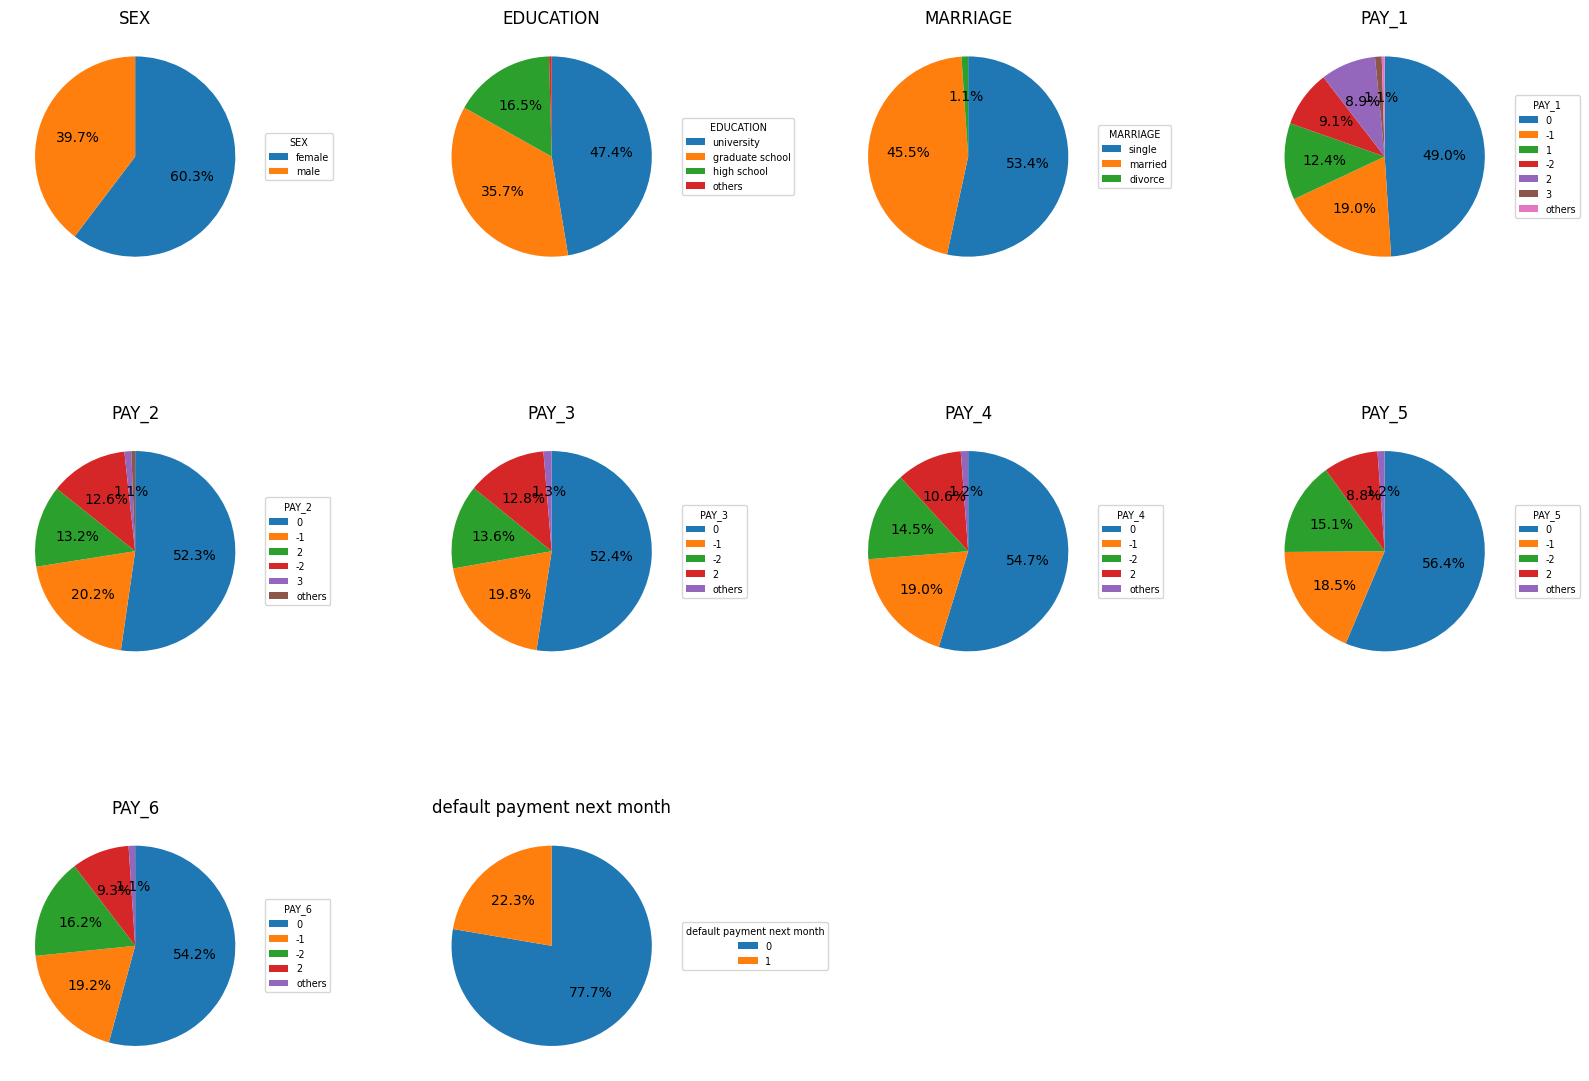

In [51]:
# Panel of pie plots for the categorical variables with smaller legend box, smaller pies, and grouping <1% as 'others'
target = 'default payment next month'

n_cols = 4
n_rows = int(np.ceil(len(categorical_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))  # smaller pies

for idx, col in enumerate(categorical_features):
    ax = axes[idx // n_cols, idx % n_cols]
    counts = data[col].value_counts(dropna=False)
    total = counts.sum()
    percentages = counts / total
    # Group categories below 1% as 'others'
    mask = percentages < 0.01
    if mask.any():
        others_count = counts[mask].sum()
        counts = counts[~mask]
        counts['others'] = others_count
    labels = [str(i) for i in counts.index]
    wedges, texts, autotexts = ax.pie(
        counts,
        labels=None,
        autopct=lambda pct: ('%1.1f%%' % pct) if pct >= 1 else '',
        startangle=90,
        counterclock=False
    )
    ax.set_title(col)
    ax.set_ylabel('')
    # Place the legend to the right of the pie and make the font smaller
    ax.legend(
        wedges, labels, title=col,
        loc='center left', bbox_to_anchor=(1, 0.5),
        fontsize='x-small', title_fontsize='x-small'
    )

# Remove empty subplots if any
for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()


/tmp/ipykernel_252522/486753936.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([col, target]).size()
/tmp/ipykernel_252522/486753936.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([col, target]).size()
/tmp/ipykernel_252522/486753936.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([col, target]).size()
/tmp/ipykernel_252522/486753936.py:14: FutureWarning: The defaul

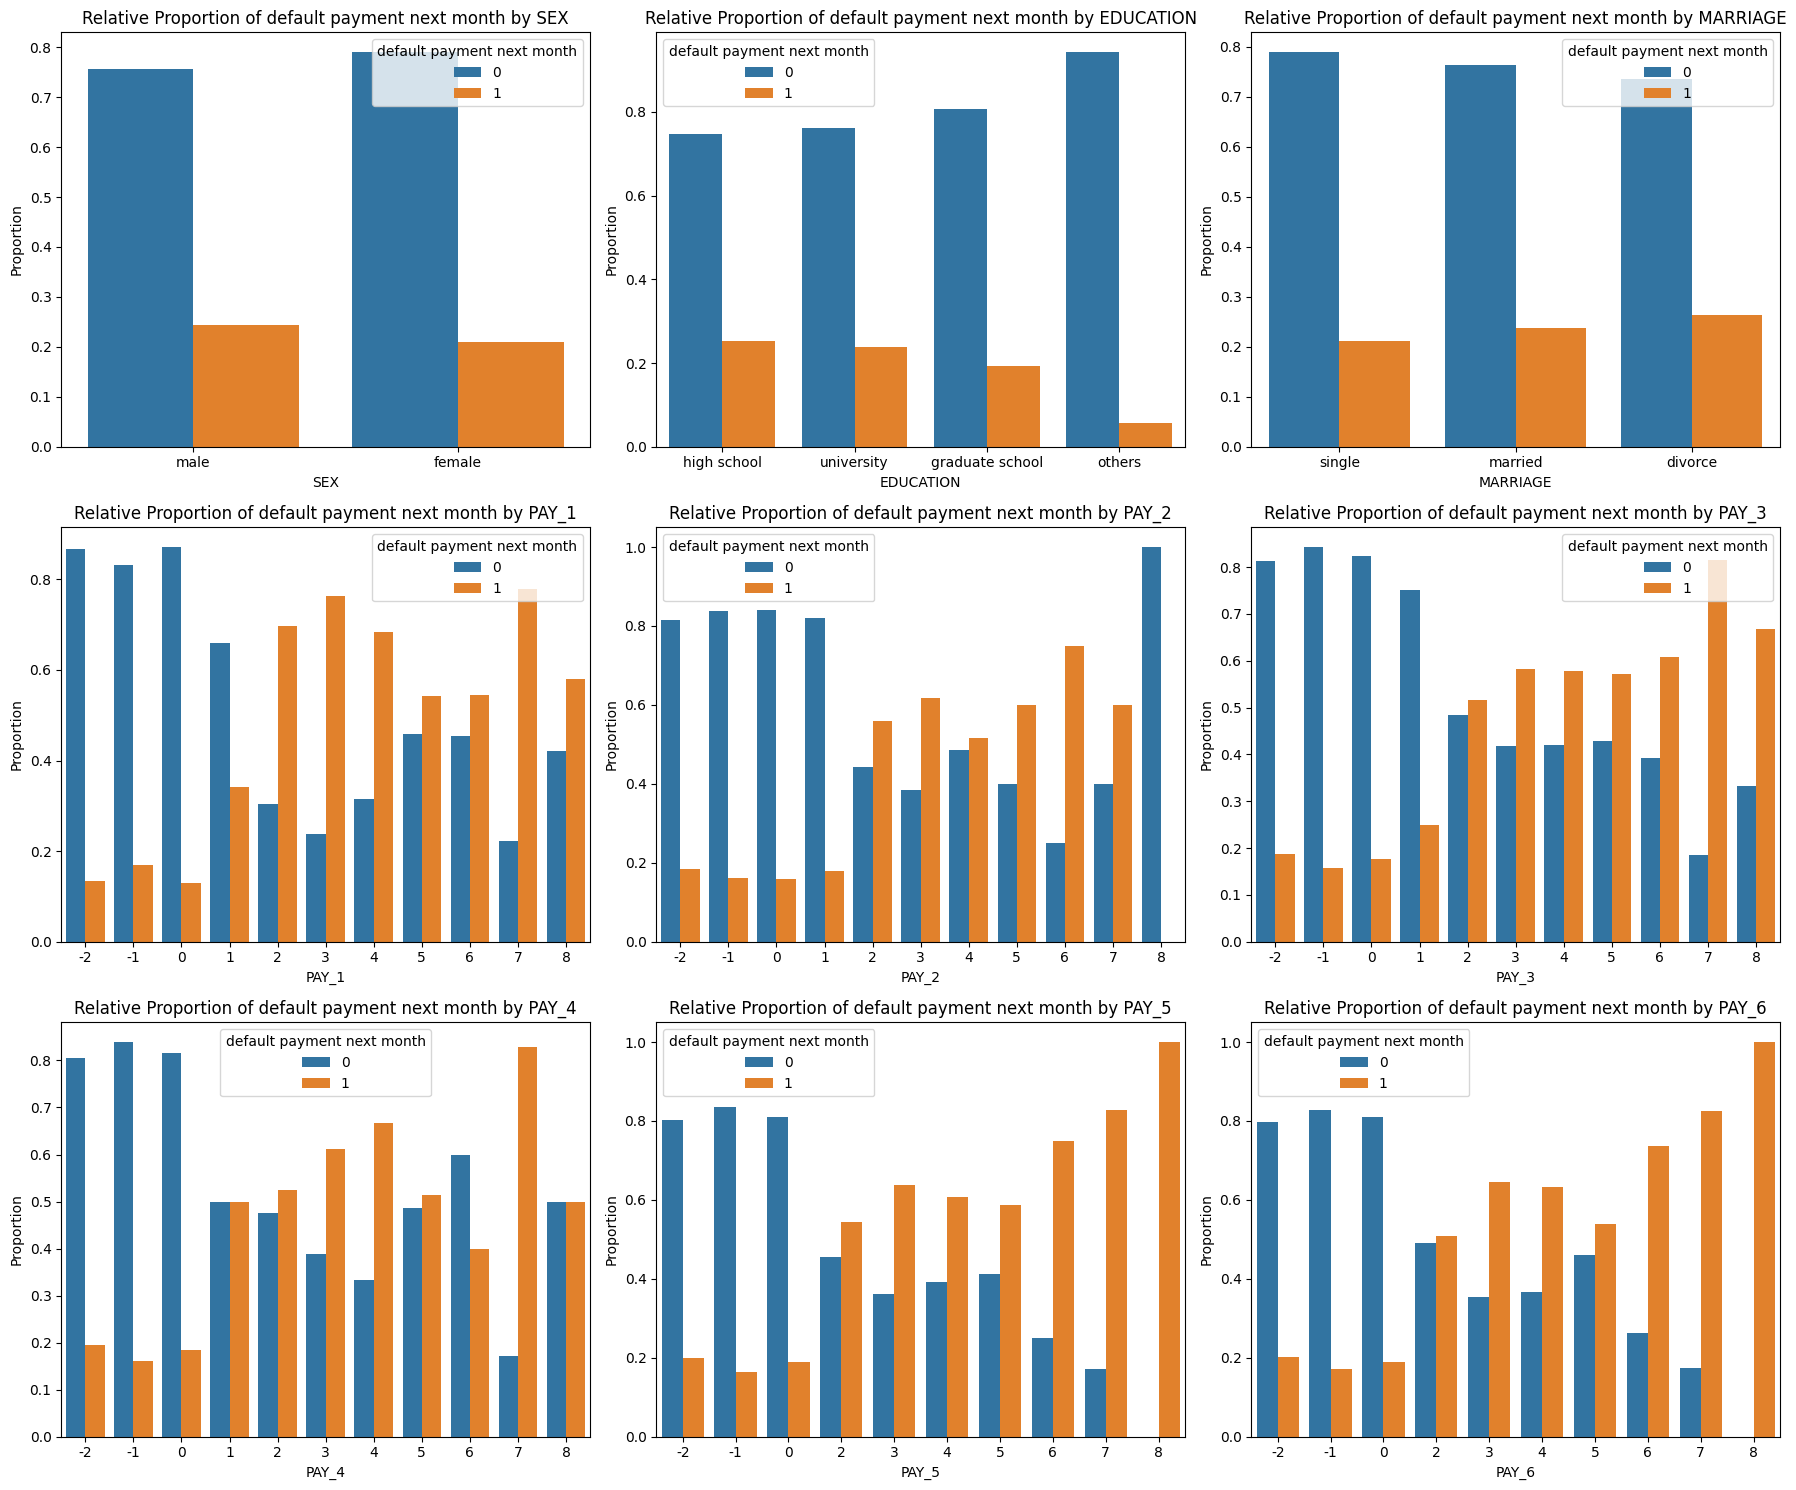

In [63]:
# Panel of categorical variable distributions by target (relative proportions)

target = 'default payment next month'
categorical_cols = [col for col in data.select_dtypes(include='category').columns if col != target]

n_cols = 3
n_rows = int(np.ceil(len(categorical_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

for idx, col in enumerate(categorical_cols):
    ax = axes[idx // n_cols, idx % n_cols]
    # Calculate proportions within each category
    prop_df = (
        data.groupby([col, target]).size()
        .groupby(level=0).transform(lambda x: x / x.sum())
        .rename('proportion')
        .reset_index()
    )
    sns.barplot(x=col, y='proportion', hue=target, data=prop_df, ax=ax)
    ax.set_title(f'Relative Proportion of {target} by {col}')
    ax.legend(title=target)
    ax.set_xlabel(col)
    ax.set_ylabel('Proportion')

# Remove empty subplots if any
for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

In [ ]:
# Analysis of Categorical Variables with respect to the target

target = 'default payment next month'
categorical_cols = [col for col in data.select_dtypes(include='category').columns if col != target]

for col in categorical_cols:
    print(f"--- {col} ---")
    print("Counts:\n", data[col].value_counts(dropna=False))
    print("Proportions:\n", data[col].value_counts(normalize=True, dropna=False))
    print("Unique values:", data[col].unique())
    print("\n")
    

--- SEX ---
Counts:
 SEX
female    18112
male      11888
Name: count, dtype: int64
Proportions:
 SEX
female    0.603733
male      0.396267
Name: proportion, dtype: float64
Unique values: ['female', 'male']
Categories (2, object): ['male', 'female']


--- EDUCATION ---
Counts:
 EDUCATION
university         14030
graduate school    10585
high school         4917
NaN                  345
others               123
Name: count, dtype: int64
Proportions:
 EDUCATION
university         0.467667
graduate school    0.352833
high school        0.163900
NaN                0.011500
others             0.004100
Name: proportion, dtype: float64
Unique values: ['university', 'graduate school', 'high school', NaN, 'others']
Categories (4, object): ['graduate school' < 'high school' < 'university' < 'others']


--- MARRIAGE ---
Counts:
 MARRIAGE
single     15964
married    13659
divorce      323
NaN           54
Name: count, dtype: int64
Proportions:
 MARRIAGE
single     0.532133
married    0.455300
divor

In [ ]:
for col in categorical_cols:
    contingency = pd.crosstab(data[col], data[target])
    chi2, p, dof, ex = chi2_contingency(contingency)
    
    # Check minimum expected frequency
    min_expected = np.min(ex)
    
    print(f"\n--- {col} ---")
    print(f"Chi-square: {chi2:.2f}")
    print(f"p-value: {p:.2e}")
    print(f"Minimum expected frequency: {min_expected:.2f}")
    
    # Calculate effect size (Cramér's V)
    n = contingency.sum().sum()
    phi2 = chi2/n
    r, k = contingency.shape
    cramers_v = np.sqrt(phi2/min(k-1, r-1))
    
    print(f"Cramér's V: {cramers_v:.4f}")


--- SEX ---
Chi-square: 47.71
p-value: 4.94e-12
Minimum expected frequency: 2629.63
Cramér's V: 0.0399

--- EDUCATION ---
Chi-square: 116.86
p-value: 3.66e-25
Minimum expected frequency: 27.42
Cramér's V: 0.0628

--- MARRIAGE ---
Chi-square: 30.45
p-value: 2.45e-07
Minimum expected frequency: 71.52
Cramér's V: 0.0319

--- PAY_0 ---
Chi-square: 5365.96
p-value: 0.00e+00
Minimum expected frequency: 1.99
Cramér's V: 0.4229

--- PAY_2 ---
Chi-square: 3474.47
p-value: 0.00e+00
Minimum expected frequency: 0.22
Cramér's V: 0.3403

--- PAY_3 ---
Chi-square: 2622.46
p-value: 0.00e+00
Minimum expected frequency: 0.66
Cramér's V: 0.2957

--- PAY_4 ---
Chi-square: 2341.47
p-value: 0.00e+00
Minimum expected frequency: 0.44
Cramér's V: 0.2794

--- PAY_5 ---
Chi-square: 2197.69
p-value: 0.00e+00
Minimum expected frequency: 0.22
Cramér's V: 0.2707

--- PAY_6 ---
Chi-square: 1886.84
p-value: 0.00e+00
Minimum expected frequency: 0.44
Cramér's V: 0.2508


### Summary of Findings about Categorical Features:

1. The dataset contains several categorical features: SEX, EDUCATION, MARRIAGE, PAY_0 to PAY_6, and the target variable 'default payment next month'.
2. After cleaning, all missing or unknown values in categorical columns were removed, resulting in 29,601 rows.
3. The distribution of categories in each feature was visualized using pie charts and count plots, with rare categories (<1%) grouped as 'others' for clarity.
4. There are clear imbalances in some features (e.g., most clients are 'female', 'university' educated, and 'married').
5. The target variable ('default payment next month') is also imbalanced, with about 22% defaults and 78% non-defaults.
6. Chi-square tests for independence between each categorical feature and the target showed significant associations (very low p-values), indicating that these features are related to default risk.
7. Effect sizes (Cramér's V) suggest moderate associations for some features (e.g., payment status variables), while others have weaker effects.
8. The minimum expected frequencies in contingency tables are generally adequate, supporting the validity of the chi-square results.

Overall, categorical features show meaningful patterns and associations with the target, justifying their inclusion in further modeling and analysis.

### 1.5. Numerical features Analysis

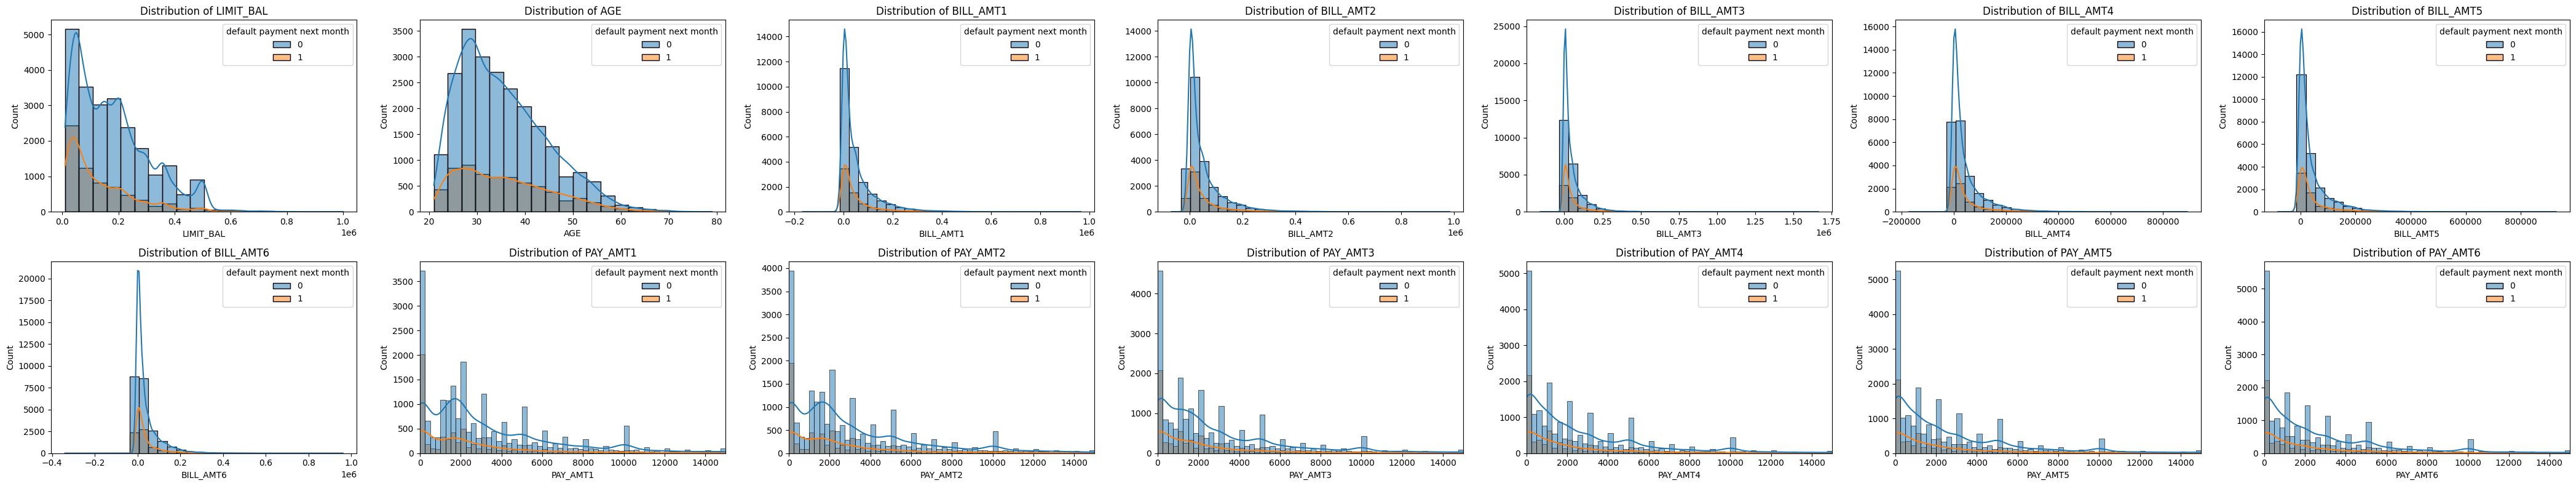

In [86]:

#bins for each feature based on their value ranges
bins_dict = {
    'LIMIT_BAL': 20,
    'AGE': 20,
    'BILL_AMT1': 30,
    'BILL_AMT2': 30,
    'BILL_AMT3': 30,
    'BILL_AMT4': 30,
    'BILL_AMT5': 30,
    'BILL_AMT6': 30,
    'PAY_AMT1': 60,
    'PAY_AMT2': 60,
    'PAY_AMT3': 60,
    'PAY_AMT4': 60,
    'PAY_AMT5': 60,
    'PAY_AMT6': 60
}

pay_amt_features = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
pay_amt_max = 15000  # Set a smaller range for PAY_AMT variables

n_cols = 7
n_rows = int(np.ceil(len(numerical_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

for idx, col in enumerate(numerical_features):
    ax = axes[idx // n_cols, idx % n_cols]
    bins = bins_dict.get(col, 60)
    if col in pay_amt_features:
        # Limit the x-axis for PAY_AMT variables
        sns.histplot(data[data[col] <= pay_amt_max], x=col, hue='default payment next month', bins=bins, kde=True, ax=ax)
        ax.set_xlim(0, pay_amt_max)
    else:
        sns.histplot(data, x=col, hue='default payment next month', bins=bins, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

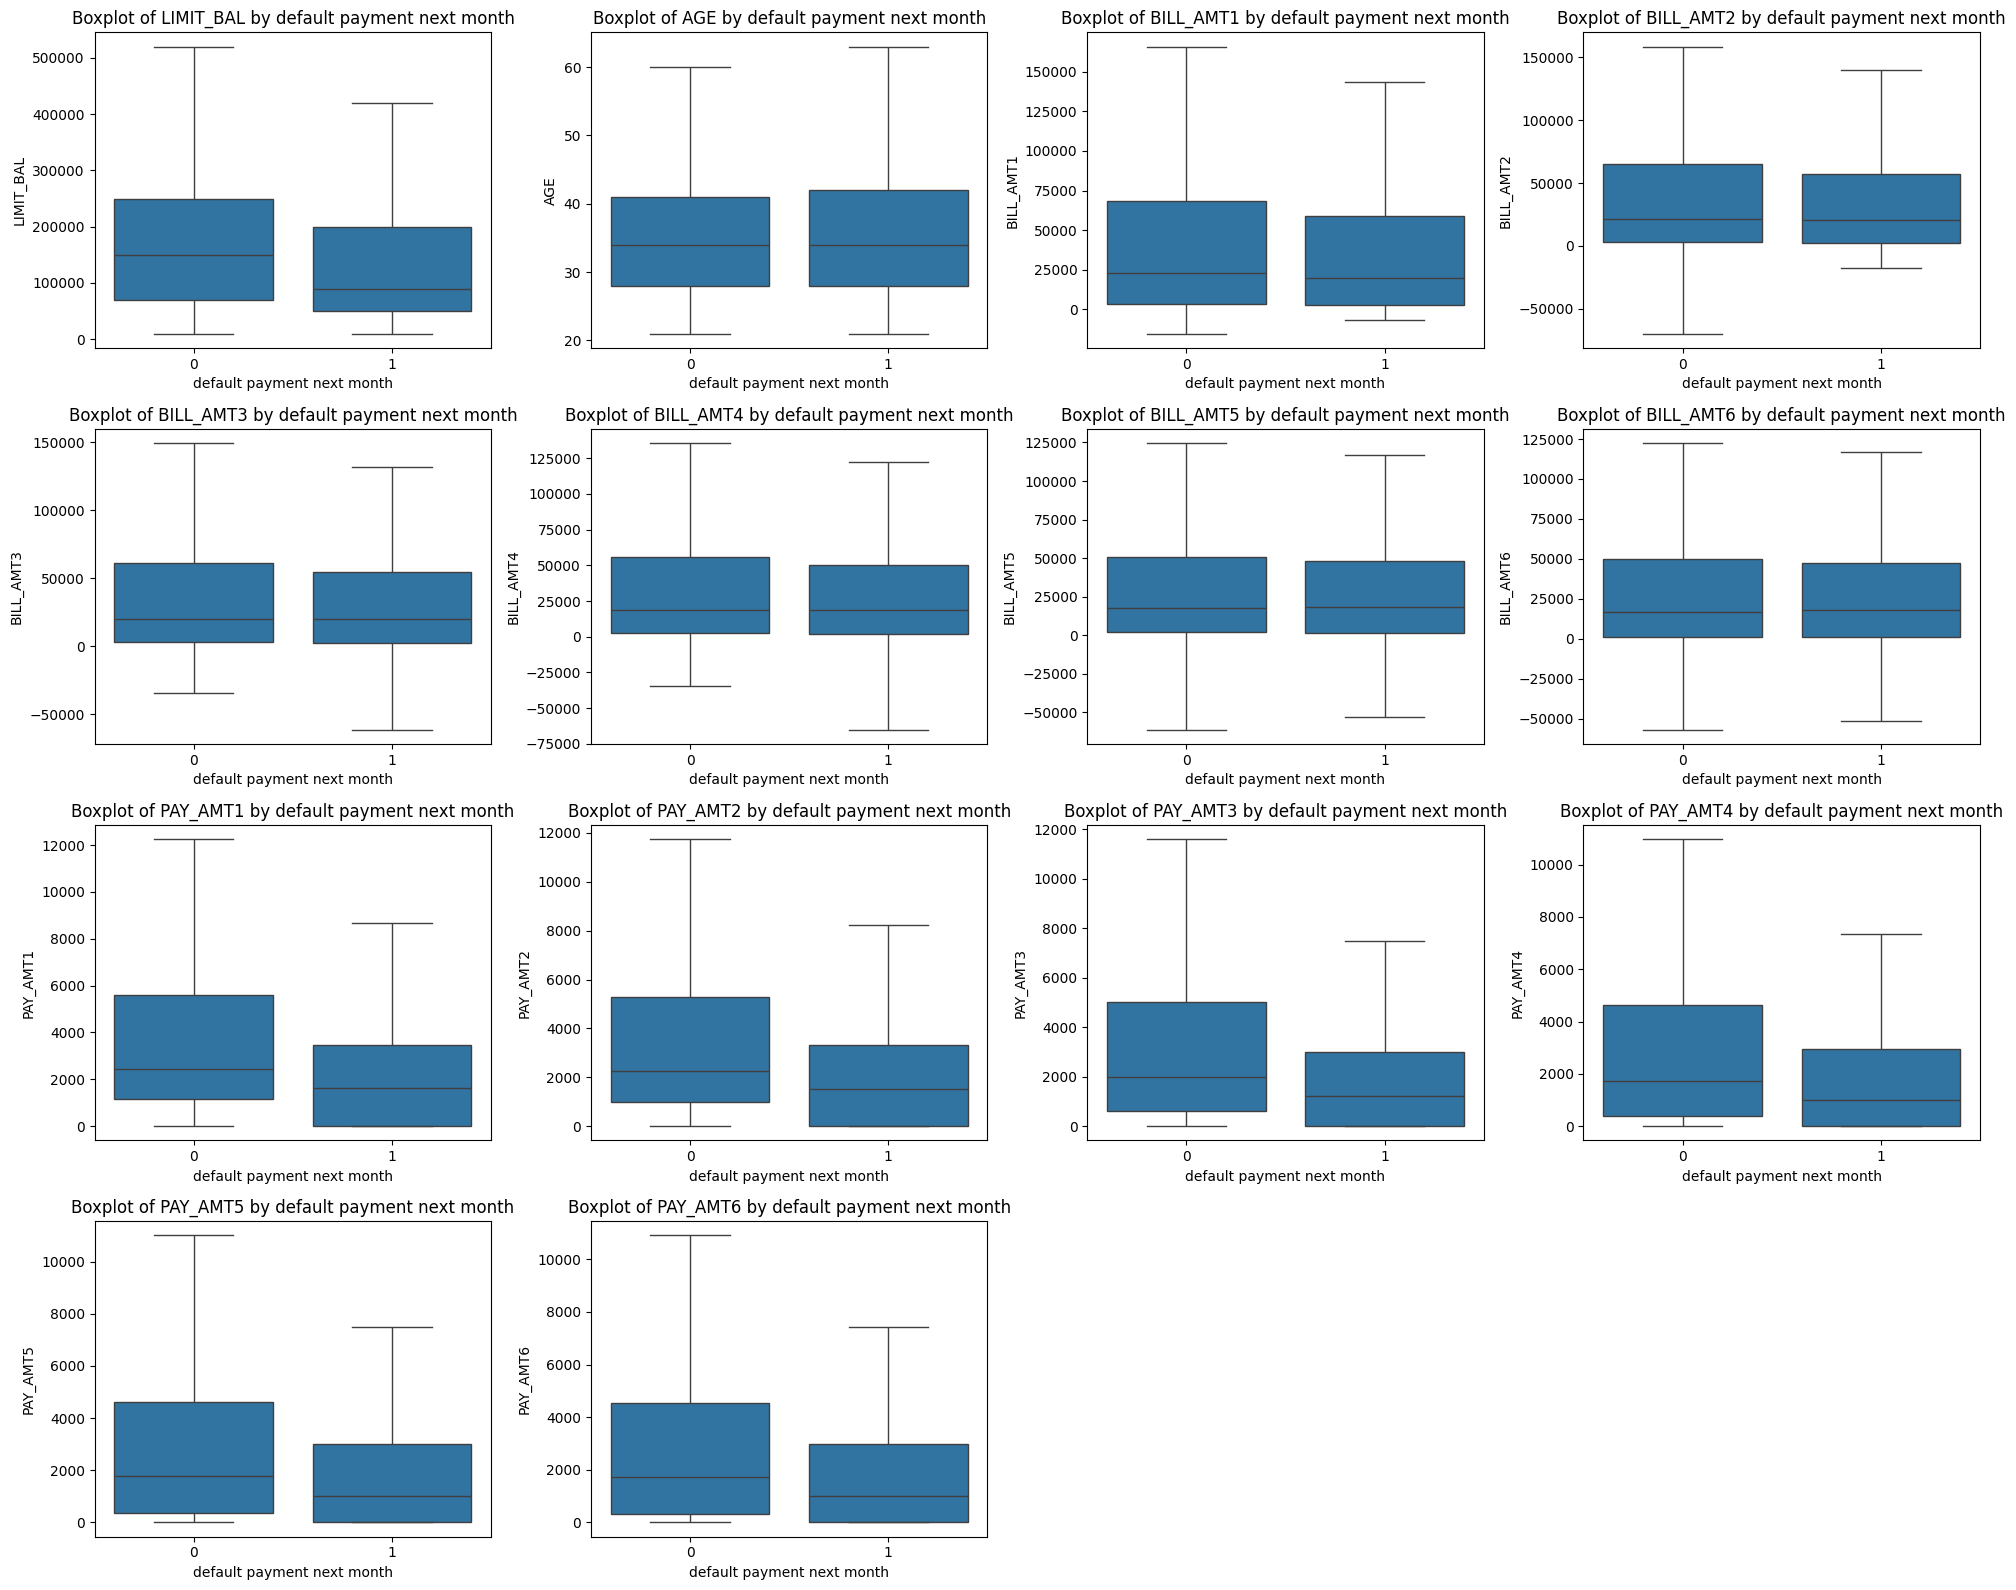

In [90]:
# Box plots for numerical features grouped by target variable

numerical_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
target = 'default payment next month'

n_cols = 4
n_rows = int(np.ceil(len(numerical_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

for idx, col in enumerate(numerical_features):
    ax = axes[idx // n_cols, idx % n_cols]
    sns.boxplot(x=target, y=col, data=data, ax=ax, showfliers=False)
    ax.set_title(f'Boxplot of {col} by {target}')
    ax.set_xlabel(target)
    ax.set_ylabel(col)

# Remove empty subplots if any
for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

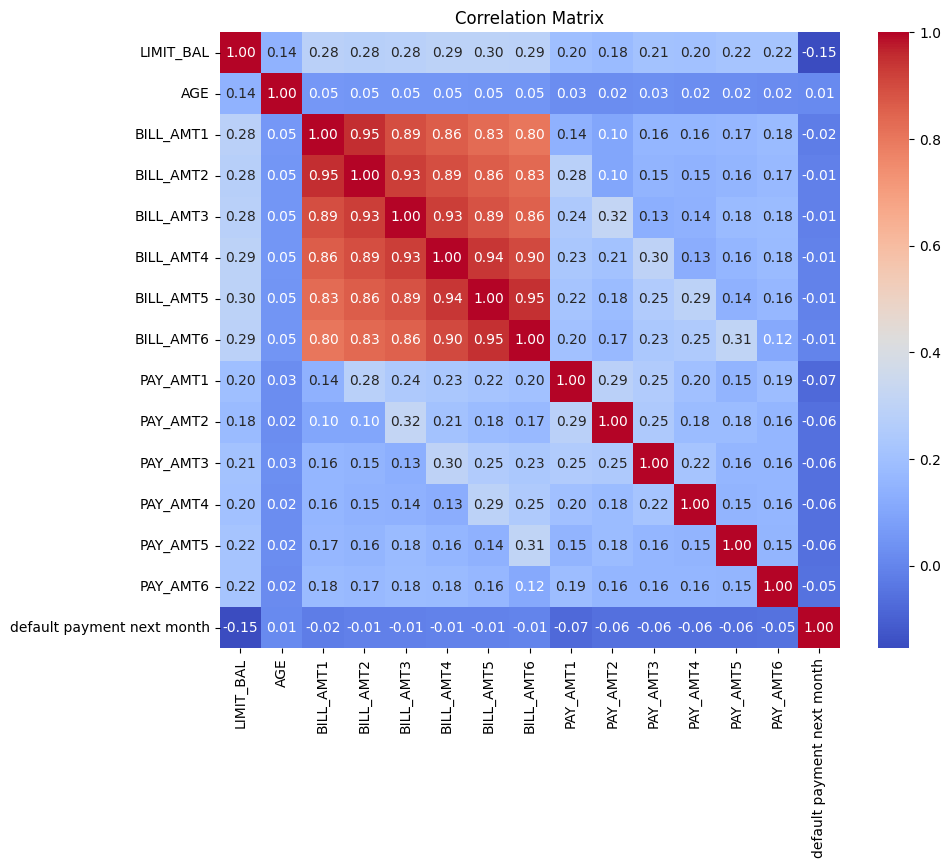

In [88]:
# Correlation heatmap with all data
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_features + [target]].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')

In [89]:
print(data.describe)

<bound method NDFrame.describe of           ID  LIMIT_BAL     SEX    EDUCATION MARRIAGE  AGE PAY_0 PAY_2 PAY_3  \
0          1      20000  female   university  married   24     2     2    -1   
1          2     120000  female   university   single   26    -1     2     0   
2          3      90000  female   university   single   34     0     0     0   
3          4      50000  female   university  married   37     0     0     0   
4          5      50000    male   university  married   57    -1     0    -1   
...      ...        ...     ...          ...      ...  ...   ...   ...   ...   
29995  29996     220000    male  high school  married   39     0     0     0   
29996  29997     150000    male  high school   single   43    -1    -1    -1   
29997  29998      30000    male   university   single   37     4     3     2   
29998  29999      80000    male  high school  married   41     1    -1     0   
29999  30000      50000    male   university  married   46     0     0     0   

     

# 2. Feature Engineering

In [18]:
# Load dataset and apply above transformations

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from src.preprocessing import load_data, preprocess_data, numerical_features, categorical_features, target

dataset_path = '../data/raw/default_of_credit_card_clients.xls'
data = load_data(dataset_path)
preprocessed_data = preprocess_data(data)

print(preprocessed_data.dtypes)

Data shape after dropping missing values: (29601, 25)
ID                              object
LIMIT_BAL                        int64
SEX                           category
EDUCATION                     category
MARRIAGE                      category
AGE                              int64
PAY_1                         category
PAY_2                         category
PAY_3                         category
PAY_4                         category
PAY_5                         category
PAY_6                         category
BILL_AMT1                        int64
BILL_AMT2                        int64
BILL_AMT3                        int64
BILL_AMT4                        int64
BILL_AMT5                        int64
BILL_AMT6                        int64
PAY_AMT1                         int64
PAY_AMT2                         int64
PAY_AMT3                         int64
PAY_AMT4                         int64
PAY_AMT5                         int64
PAY_AMT6                         int64
default pa

### 2.1 Creating new variables


**Transformation of PAY_0 to PAY_6 Variables**

The original variables **PAY_0 to PAY_6** represent the repayment status for the past 7 months, with values:
- **-2**: No consumption
- **-1**: Paid duly (on time)
- **0, 1, 2, ...**: Number of months payment is delayed

Why transform these variables?**

- The original encoding mixes special cases (no consumption, paid duly) with ordinal delay values, which can confuse machine learning models.
- By separating these cases, we make the data more interpretable and allow models to better distinguish between good payment behavior and payment delays.
- This transformation also enables us to use the delay as a true ordinal feature.

Transformation steps**

For each PAY_X column (where X = 0 to 6):
1. **Create two binary features:**
   - `PAY_X_no_consumption`: 1 if value is -2 (no consumption), else 0
   - `PAY_X_paid_duly`: 1 if value is -1 (paid duly), else 0
2. **Create an ordinal delay feature:**
   - `PAY_X_delay`: 0 if value is -2 or -1 (no delay), otherwise the number of months delayed (original value if ≥ 0)

**Create variables avg_bill**

**Dummify variables MARRIAGE, SEX and EDUCATION**




In [19]:
# Create a new dataset with engineered PAY_X features and remove the original PAY_X columns

# List of PAY_X columns to transform and remove
pay_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Create new features
for col in pay_cols:
    preprocessed_data[f'{col}_no_consumption'] = (preprocessed_data[col] == -2).astype(bool)
    preprocessed_data[f'{col}_paid_duly'] = (preprocessed_data[col] == -1).astype(bool)
    preprocessed_data[f'{col}_delay'] = preprocessed_data[col].apply(lambda x: 0 if x < 0 else x)
preprocessed_data[target] = preprocessed_data[target].astype(int)

# Sanity check: ensure new columns exist and original columns will be dropped
print("New columns added:", [f"{col}_no_consumption" for col in pay_cols] +
      [f"{col}_paid_duly" for col in pay_cols] +
      [f"{col}_delay" for col in pay_cols])

# Remove the original PAY_X columns
preprocessed_data = preprocessed_data.drop(columns=pay_cols)

preprocessed_data['avg_bill'] = preprocessed_data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
preprocessed_data['avg_bill'] = preprocessed_data['avg_bill'].astype(float)

print(preprocessed_data.dtypes)


New columns added: ['PAY_1_no_consumption', 'PAY_2_no_consumption', 'PAY_3_no_consumption', 'PAY_4_no_consumption', 'PAY_5_no_consumption', 'PAY_6_no_consumption', 'PAY_1_paid_duly', 'PAY_2_paid_duly', 'PAY_3_paid_duly', 'PAY_4_paid_duly', 'PAY_5_paid_duly', 'PAY_6_paid_duly', 'PAY_1_delay', 'PAY_2_delay', 'PAY_3_delay', 'PAY_4_delay', 'PAY_5_delay', 'PAY_6_delay']
ID                              object
LIMIT_BAL                        int64
SEX                           category
EDUCATION                     category
MARRIAGE                      category
AGE                              int64
BILL_AMT1                        int64
BILL_AMT2                        int64
BILL_AMT3                        int64
BILL_AMT4                        int64
BILL_AMT5                        int64
BILL_AMT6                        int64
PAY_AMT1                         int64
PAY_AMT2                         int64
PAY_AMT3                         int64
PAY_AMT4                         int64
PAY_AMT5

In [9]:
from src.feature_engineering import set_types_encoded

# Dummyfication (one-hot encoding) of categorical variables in new_data

# Exclude the target variable from dummyfication
categorical_to_dummy = [col for col in preprocessed_data.select_dtypes(include='category').columns if col != target]

# Perform one-hot encoding, keeping the target as category
data_encoded = pd.get_dummies(preprocessed_data, columns=categorical_to_dummy, drop_first=False)

data_encoded = set_types_encoded(data_encoded)
# Show the resulting columns and shape
print("Encoded data shape:", data_encoded.shape)
print("Columns after dummyfication:", data_encoded.columns.tolist())
print("Shape of data after dummyfication:", data_encoded.shape)
print("Data types after dummyfication:\n", data_encoded.dtypes)
print(data_encoded.head())

Encoded data shape: (29601, 44)
Columns after dummyfication: ['ID', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month', 'PAY_1_no_consumption', 'PAY_1_paid_duly', 'PAY_1_delay', 'PAY_2_no_consumption', 'PAY_2_paid_duly', 'PAY_2_delay', 'PAY_3_no_consumption', 'PAY_3_paid_duly', 'PAY_3_delay', 'PAY_4_no_consumption', 'PAY_4_paid_duly', 'PAY_4_delay', 'PAY_5_no_consumption', 'PAY_5_paid_duly', 'PAY_5_delay', 'PAY_6_no_consumption', 'PAY_6_paid_duly', 'PAY_6_delay', 'avg_bill', 'SEX_male', 'SEX_female', 'EDUCATION_high school', 'EDUCATION_university', 'EDUCATION_graduate school', 'EDUCATION_others', 'MARRIAGE_single', 'MARRIAGE_married', 'MARRIAGE_divorce']
Shape of data after dummyfication: (29601, 44)
Data types after dummyfication:
 ID                             object
LIMIT_BAL                       int64
AGE                             i

## 2.1 PCA

Explained variance ratio (first 15 components): [0.18953136 0.1177717  0.11194923 0.06239986 0.05691901 0.04807772
 0.03740635 0.03258113 0.02725939 0.02502439 0.0240737  0.02387925
 0.02257125 0.02195441 0.02095311]
Cumulative explained variance (first 15 components): [0.18953136 0.30730306 0.41925229 0.48165216 0.53857117 0.58664889
 0.62405523 0.65663636 0.68389575 0.70892014 0.73299384 0.75687309
 0.77944434 0.80139875 0.82235186]


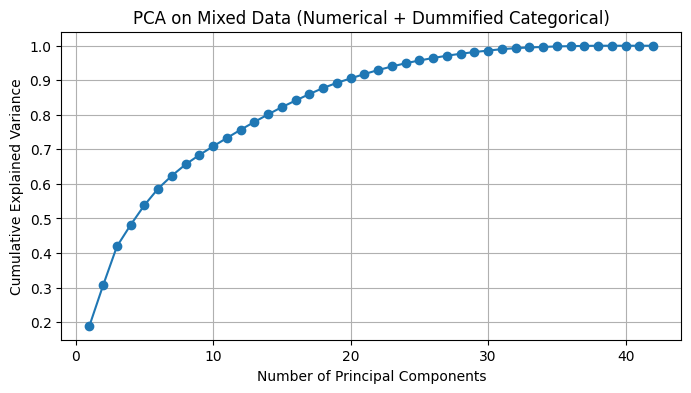

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data for PCA: use only numerical columns from data_encoded
# Exclude ID and target variable
pca_features = [col for col in data_encoded.columns if data_encoded[col].dtype in [np.int64, np.float64, bool] and col not in ['ID', 'default payment next month']]
X = data_encoded[pca_features].astype(float)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

print("Explained variance ratio (first 15 components):", explained_var[:15])
print("Cumulative explained variance (first 15 components):", cumulative_var[:15])




# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(cumulative_var) + 1), cumulative_var, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA on Mixed Data (Numerical + Dummified Categorical)')
plt.grid(True)
plt.show()

Creating comprehensive PCA feature analysis...


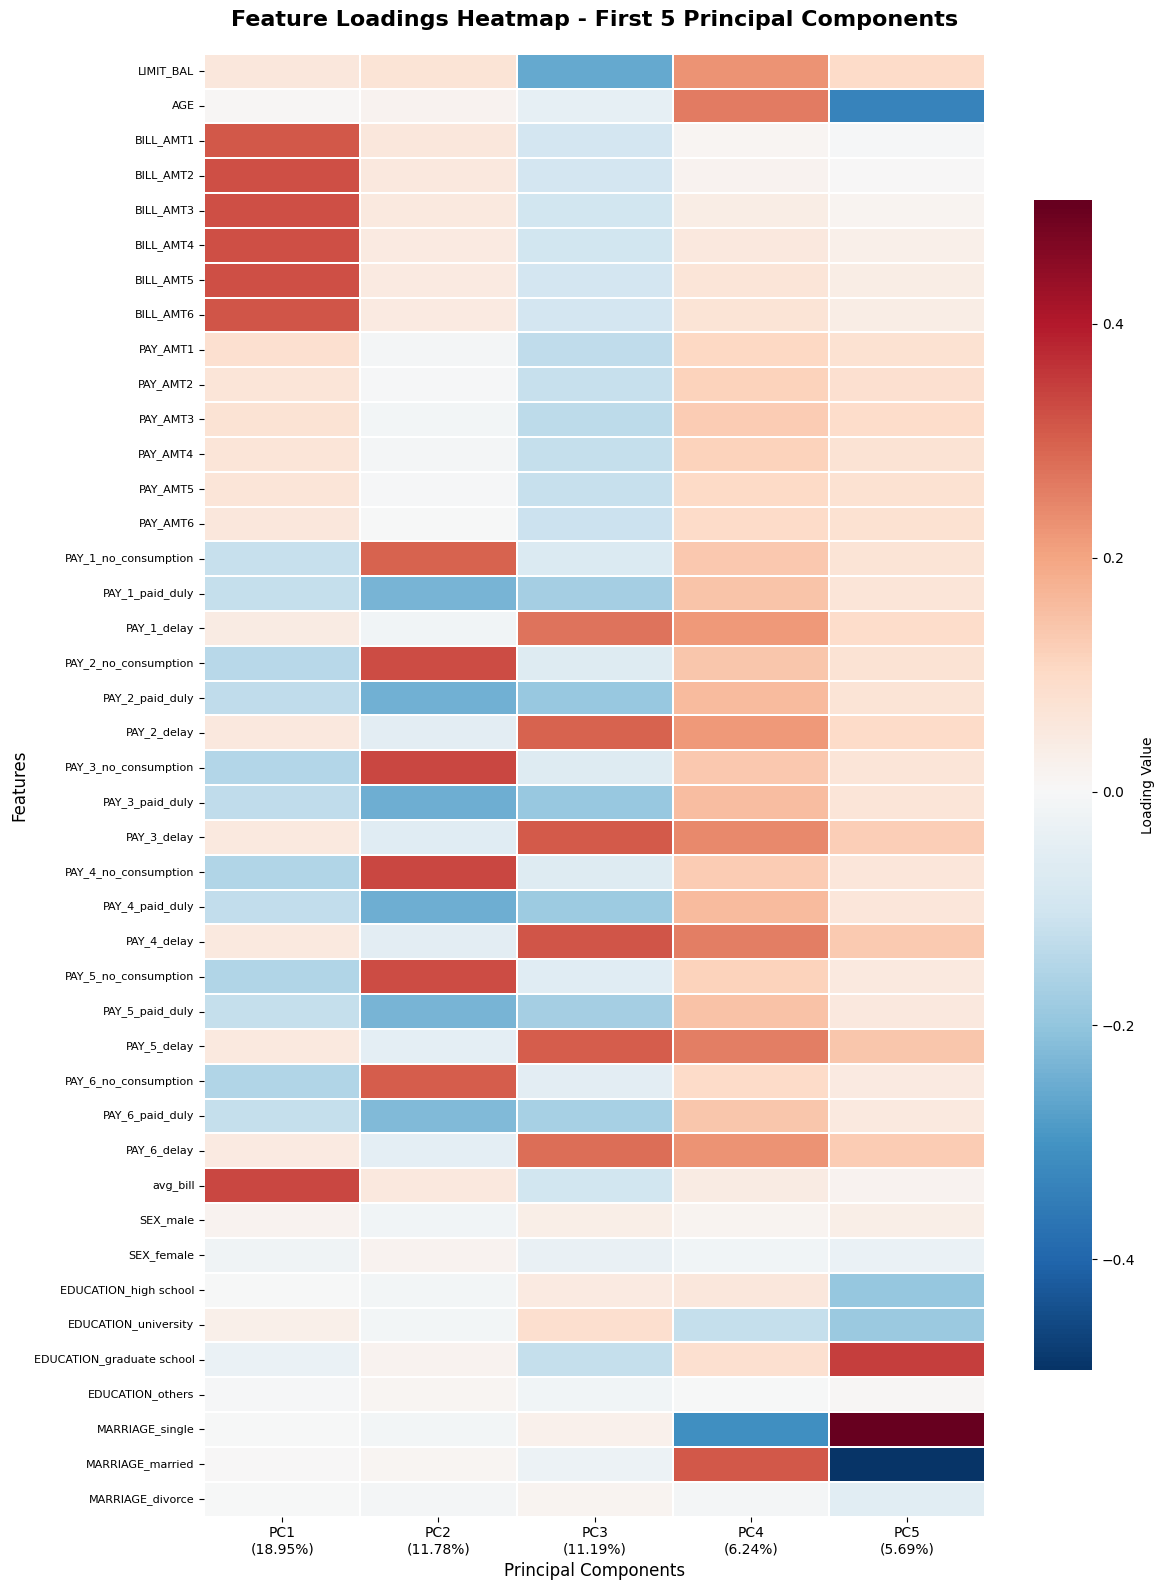

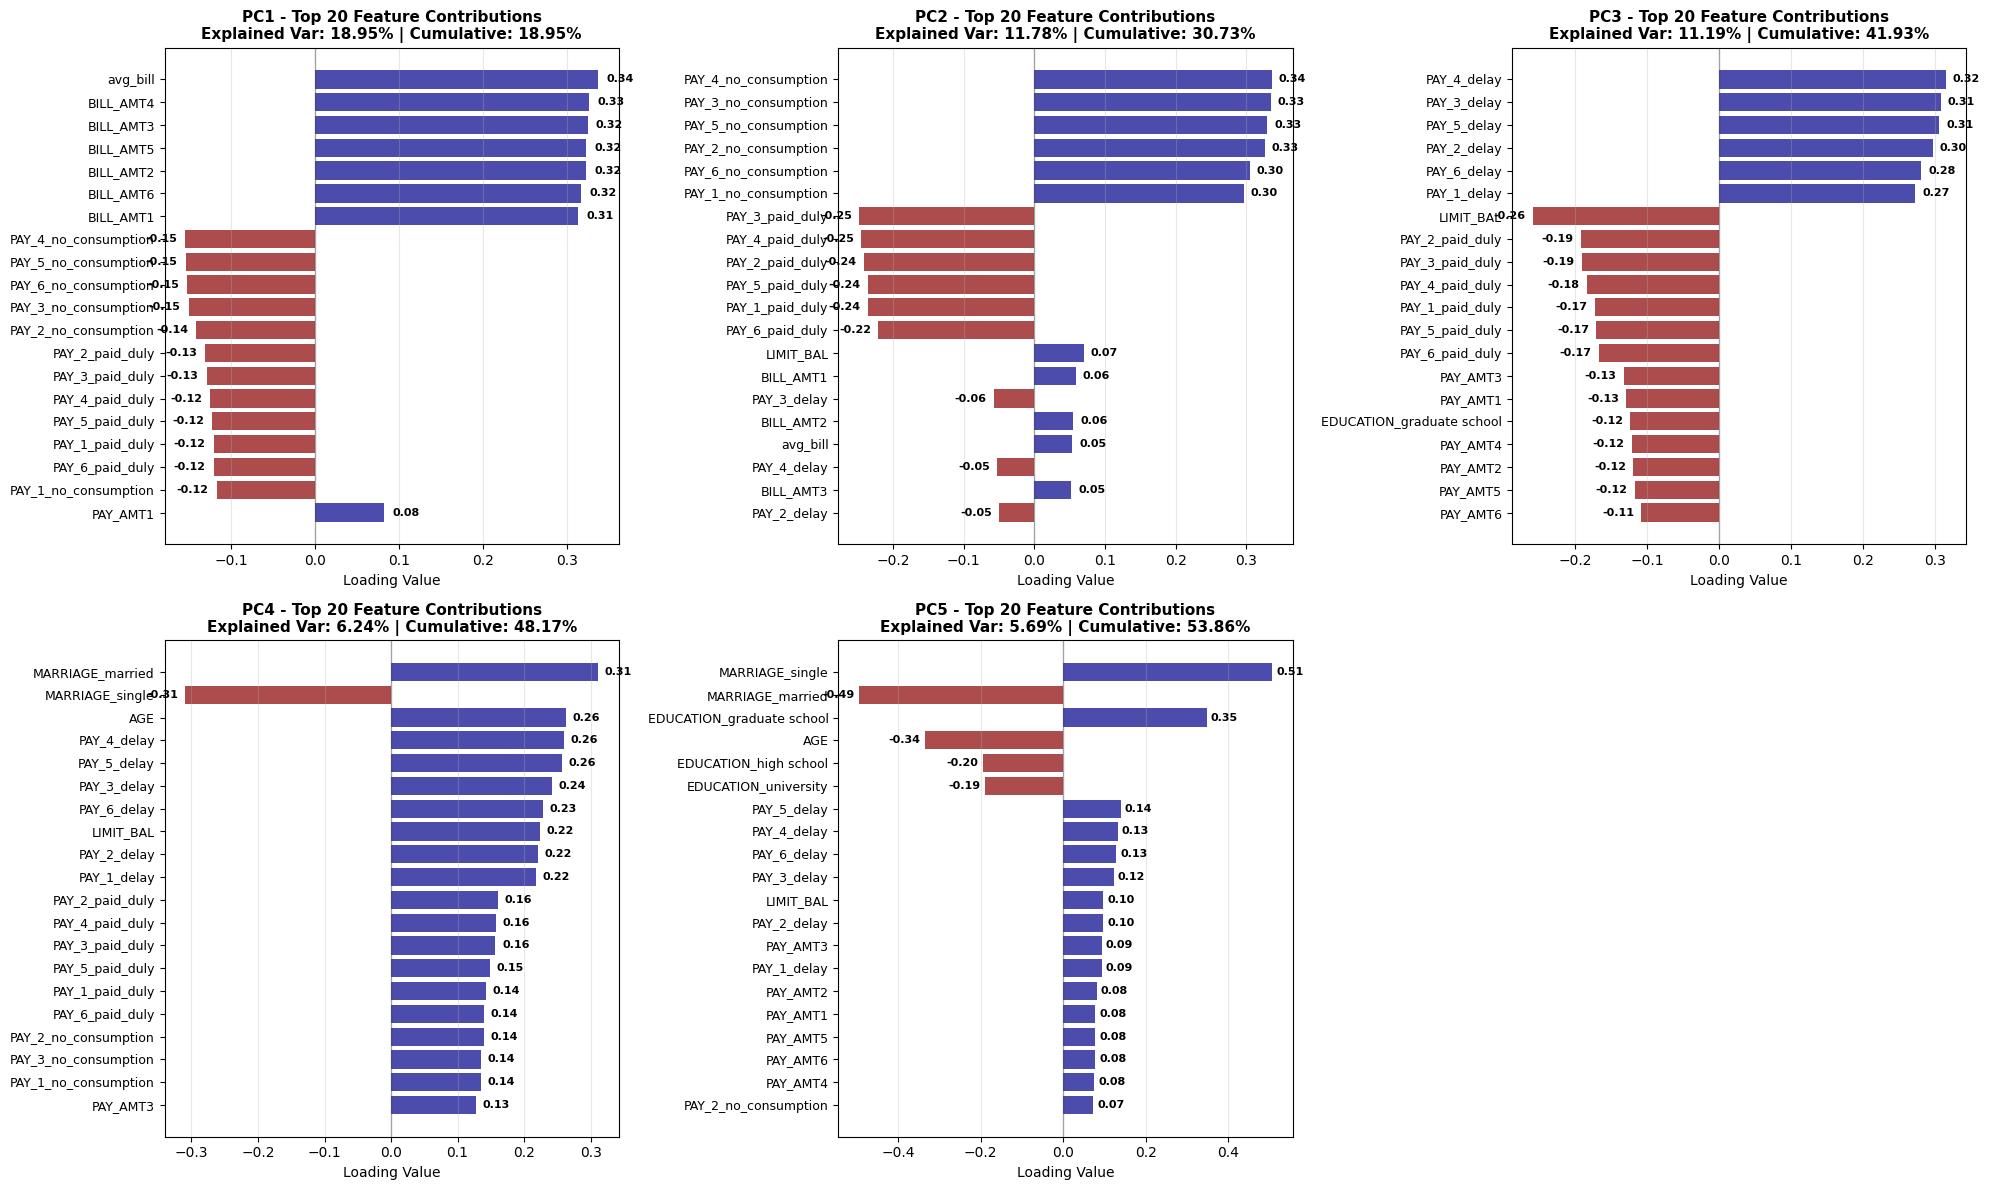


Analyzing feature groups in detail...


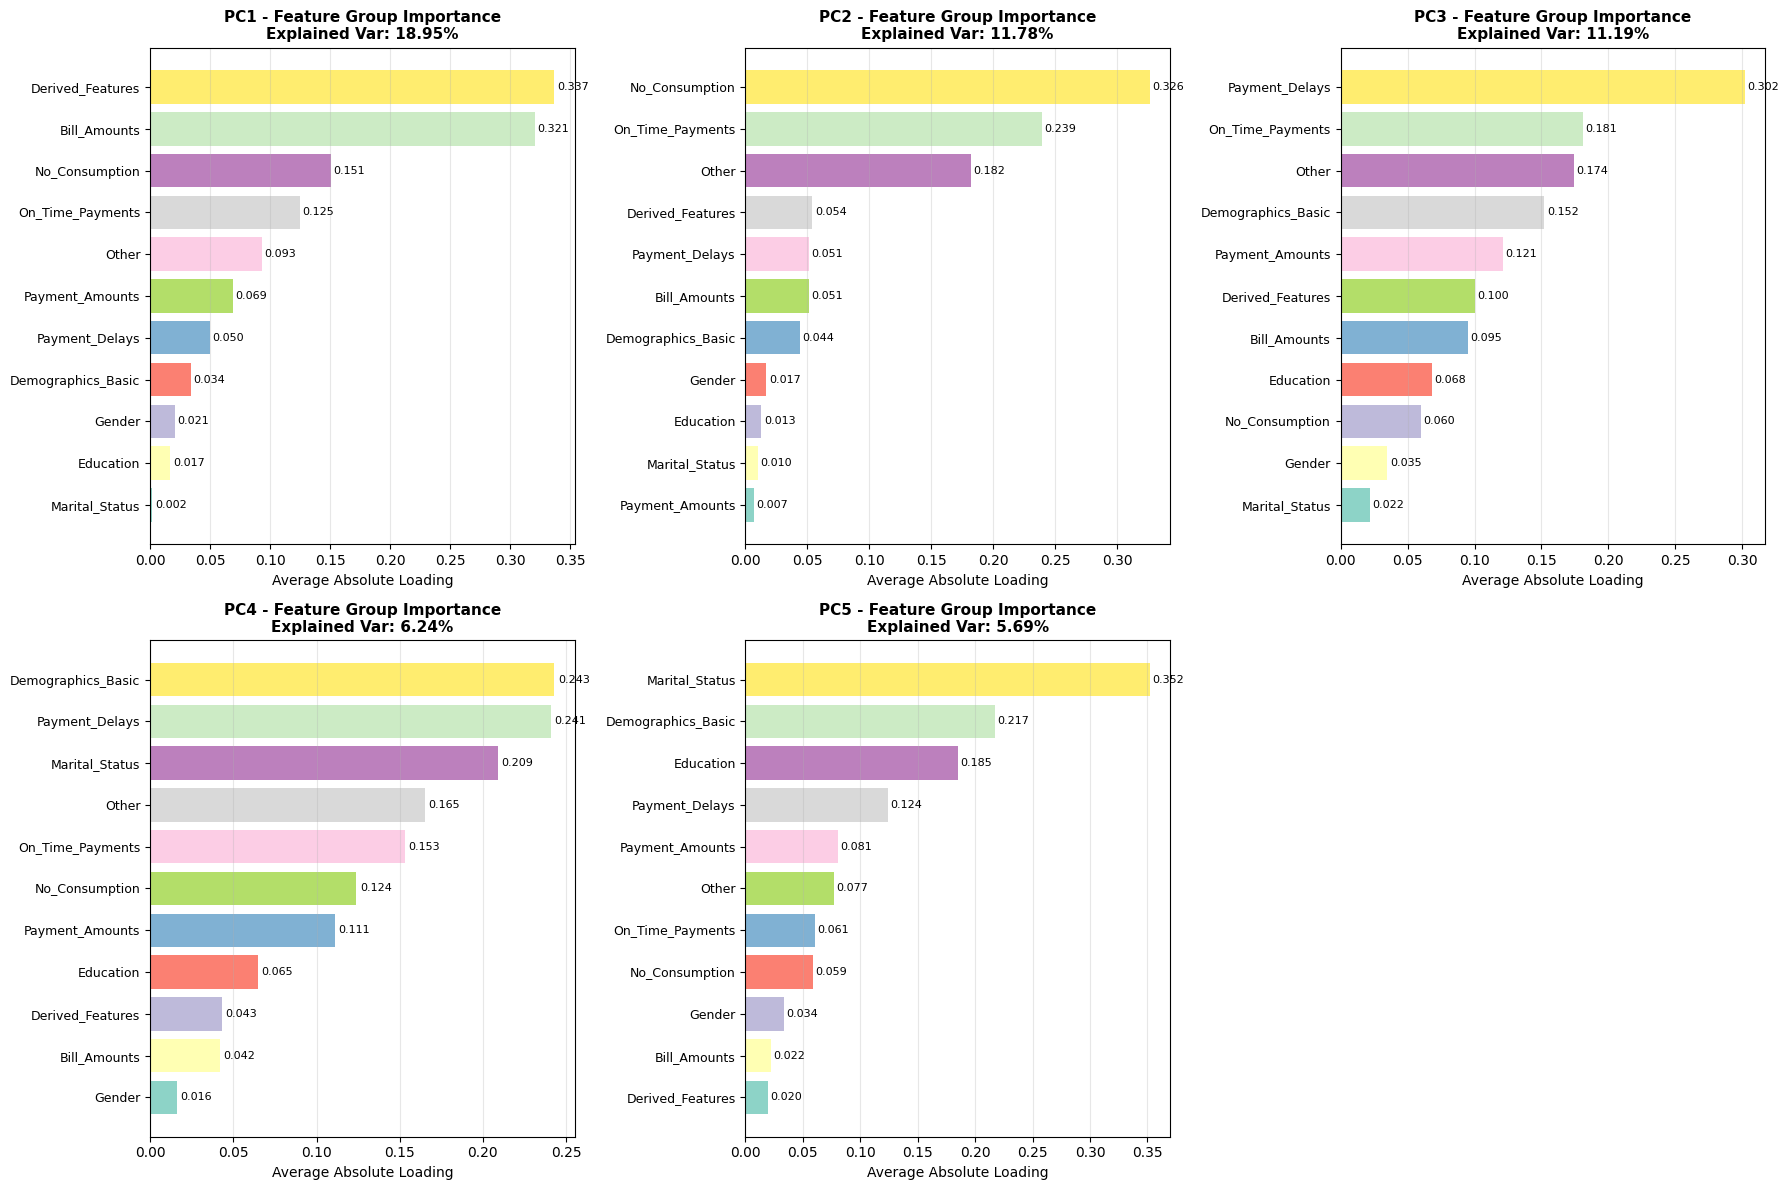

DETAILED PCA ANALYSIS SUMMARY

Dataset Summary:
  • Total features analyzed: 42
  • Principal components analyzed: 5
  • Total variance explained by first 5 PCs: 53.86%

Variance Explanation by Component:
  • PC1: 18.95% (Cumulative: 18.95%)
  • PC2: 11.78% (Cumulative: 30.73%)
  • PC3: 11.19% (Cumulative: 41.93%)
  • PC4: 6.24% (Cumulative: 48.17%)
  • PC5: 5.69% (Cumulative: 53.86%)

Top Contributors by Principal Component:

  PC1 (Explains 18.95% of variance):
    Top Positive Contributors:
      • avg_bill: 0.337
      • BILL_AMT4: 0.326
      • BILL_AMT3: 0.324
      • BILL_AMT5: 0.323
      • BILL_AMT2: 0.322
    Top Negative Contributors:
      • PAY_4_no_consumption: -0.155
      • PAY_5_no_consumption: -0.154
      • PAY_6_no_consumption: -0.152
      • PAY_3_no_consumption: -0.151
      • PAY_2_no_consumption: -0.141

  PC2 (Explains 11.78% of variance):
    Top Positive Contributors:
      • PAY_4_no_consumption: 0.336
      • PAY_3_no_consumption: 0.334
      • PAY_5_no_con

In [11]:
# Enhanced Feature Contributions to Principal Components

def plot_comprehensive_pca_analysis(pca, feature_names, explained_var, cumulative_var, n_components=5):
    """
    Create comprehensive PCA analysis plots showing all feature contributions.
    """
    
    # Get the components (loadings matrix)
    components = pca.components_[:n_components]
    
    # Create loadings DataFrame
    loadings_df = pd.DataFrame(
        components.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=feature_names
    )
    
    # 1. Comprehensive Feature Loadings Heatmap
    plt.figure(figsize=(12, max(16, len(feature_names) * 0.3)))
    
    # Create heatmap with better formatting
    sns.heatmap(loadings_df, 
                cmap='RdBu_r', 
                center=0, 
                annot=False,
                fmt='.2f',
                cbar_kws={'label': 'Loading Value', 'shrink': 0.8},
                linewidths=0.1)
    
    plt.title('Feature Loadings Heatmap - First 5 Principal Components', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Principal Components', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0, fontsize=8)
    
    # Add explained variance to x-axis labels
    pc_labels = [f'PC{i+1}\n({explained_var[i]:.2%})' for i in range(n_components)]
    plt.gca().set_xticklabels(pc_labels)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Individual PC Analysis - Top Contributors
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    for i in range(n_components):
        ax = axes[i]
        
        # Get loadings for this component
        pc_loadings = loadings_df[f'PC{i+1}'].copy()
        
        # Sort by absolute loading value and take top 20
        pc_loadings_abs = pc_loadings.abs().sort_values(ascending=True)
        top_features = pc_loadings_abs.tail(20)
        
        # Get actual loadings for top features (preserving sign)
        top_loadings = pc_loadings[top_features.index]
        
        # Create colors based on positive/negative
        colors = ['darkred' if x < 0 else 'darkblue' for x in top_loadings]
        
        # Create horizontal bar plot
        bars = ax.barh(range(len(top_loadings)), top_loadings.values, color=colors, alpha=0.7)
        ax.set_yticks(range(len(top_loadings)))
        ax.set_yticklabels(top_loadings.index, fontsize=9)
        ax.set_xlabel('Loading Value', fontsize=10)
        ax.set_title(f'PC{i+1} - Top 20 Feature Contributions\n'
                    f'Explained Var: {explained_var[i]:.2%} | '
                    f'Cumulative: {cumulative_var[i]:.2%}', 
                    fontsize=11, fontweight='bold')
        
        # Add vertical line at 0
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for j, (bar, val) in enumerate(zip(bars, top_loadings.values)):
            if abs(val) > 0.05:  # Only label significant loadings
                ax.text(val + (0.01 if val > 0 else -0.01), bar.get_y() + bar.get_height()/2, 
                       f'{val:.2f}', va='center', ha='left' if val > 0 else 'right', 
                       fontsize=8, fontweight='bold')
    
    # Remove empty subplot
    axes[5].remove()
    
    plt.tight_layout()
    plt.show()
    
    return loadings_df

def analyze_feature_groups_detailed(loadings_df, explained_var, n_components=5):
    """
    Detailed analysis of feature group contributions to PCs.
    """
    
    def categorize_feature(feature_name):
        """Categorize features into meaningful groups."""
        if any(pay_col in feature_name for pay_col in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']):
            if 'delay' in feature_name:
                return 'Payment_Delays'
            elif 'paid_duly' in feature_name:
                return 'On_Time_Payments'
            elif 'no_consumption' in feature_name:
                return 'No_Consumption'
            else:
                return 'Payment_Status'
        elif feature_name.startswith('SEX_'):
            return 'Gender'
        elif feature_name.startswith('EDUCATION_'):
            return 'Education'
        elif feature_name.startswith('MARRIAGE_'):
            return 'Marital_Status'
        elif feature_name in ['LIMIT_BAL', 'AGE']:
            return 'Demographics_Basic'
        elif feature_name.startswith('BILL_AMT'):
            return 'Bill_Amounts'
        elif feature_name.startswith('PAY_AMT'):
            return 'Payment_Amounts'
        elif feature_name == 'avg_bill':
            return 'Derived_Features'
        else:
            return 'Other'
    
    # Categorize all features
    feature_categories = {feat: categorize_feature(feat) for feat in loadings_df.index}
    
    # Create detailed analysis
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    category_summary = {}
    
    for i in range(n_components):
        pc_col = f'PC{i+1}'
        ax = axes[i]
        
        # Create DataFrame with categories and loadings
        analysis_df = pd.DataFrame({
            'feature': loadings_df.index,
            'loading': loadings_df[pc_col],
            'abs_loading': np.abs(loadings_df[pc_col]),
            'category': [feature_categories[feat] for feat in loadings_df.index]
        })
        
        # Group by category and calculate statistics
        category_stats = analysis_df.groupby('category').agg({
            'abs_loading': ['mean', 'max', 'sum', 'count'],
            'loading': ['mean']
        }).round(3)
        
        # Flatten column names
        category_stats.columns = ['_'.join(col).strip() for col in category_stats.columns]
        category_stats = category_stats.reset_index()
        category_stats = category_stats.sort_values('abs_loading_mean', ascending=True)
        
        # Store for summary
        category_summary[pc_col] = category_stats
        
        # Plot
        bars = ax.barh(range(len(category_stats)), category_stats['abs_loading_mean'], 
                      color=plt.cm.Set3(np.linspace(0, 1, len(category_stats))))
        
        ax.set_yticks(range(len(category_stats)))
        ax.set_yticklabels(category_stats['category'], fontsize=9)
        ax.set_xlabel('Average Absolute Loading', fontsize=10)
        ax.set_title(f'PC{i+1} - Feature Group Importance\n'
                    f'Explained Var: {explained_var[i]:.2%}', fontsize=11, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for j, (bar, val) in enumerate(zip(bars, category_stats['abs_loading_mean'])):
            ax.text(val + 0.002, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
                   va='center', fontsize=8)
    
    # Remove empty subplot
    axes[5].remove()
    
    plt.tight_layout()
    plt.show()
    
    return category_summary

def create_detailed_summary(loadings_df, explained_var, cumulative_var, n_components=5):
    """
    Create a detailed text summary of PCA results.
    """
    print("=" * 80)
    print("DETAILED PCA ANALYSIS SUMMARY")
    print("=" * 80)
    
    print(f"\nDataset Summary:")
    print(f"  • Total features analyzed: {len(loadings_df)}")
    print(f"  • Principal components analyzed: {n_components}")
    print(f"  • Total variance explained by first {n_components} PCs: {cumulative_var[n_components-1]:.2%}")
    
    print(f"\nVariance Explanation by Component:")
    for i in range(n_components):
        print(f"  • PC{i+1}: {explained_var[i]:.2%} (Cumulative: {cumulative_var[i]:.2%})")
    
    print(f"\nTop Contributors by Principal Component:")
    for i in range(n_components):
        pc_col = f'PC{i+1}'
        top_positive = loadings_df[pc_col].nlargest(5)
        top_negative = loadings_df[pc_col].nsmallest(5)
        
        print(f"\n  PC{i+1} (Explains {explained_var[i]:.2%} of variance):")
        print(f"    Top Positive Contributors:")
        for feat, loading in top_positive.items():
            print(f"      • {feat}: {loading:.3f}")
        print(f"    Top Negative Contributors:")
        for feat, loading in top_negative.items():
            print(f"      • {feat}: {loading:.3f}")
    
    # Feature importance ranking
    print(f"\nOverall Feature Importance (sum of absolute loadings across first {n_components} PCs):")
    feature_importance = loadings_df.abs().sum(axis=1).sort_values(ascending=False)
    for i, (feat, importance) in enumerate(feature_importance.head(10).items()):
        print(f"  {i+1:2d}. {feat}: {importance:.3f}")

# Run the enhanced analysis
print("Creating comprehensive PCA feature analysis...")

# Create comprehensive analysis
loadings_df = plot_comprehensive_pca_analysis(pca, pca_features, explained_var, cumulative_var, n_components=5)

# Analyze feature groups
print("\nAnalyzing feature groups in detail...")
category_summary = analyze_feature_groups_detailed(loadings_df, explained_var, n_components=5)

# Create detailed summary
create_detailed_summary(loadings_df, explained_var, cumulative_var, n_components=5)

# Optional: Save results
print(f"\nSaving loadings matrix...")
loadings_df.to_csv('../data/processed/PCA/pca_loadings_matrix.csv', index=True)
print("Loadings matrix saved to '../data/processed/PCA/pca_loadings_matrix.csv'")

## 2.2 mRMR

In [61]:
# Implementation of mRMR (Minimum Redundancy Maximum Relevance) Feature Selection

from feature_engine.selection import MRMR
from sklearn.preprocessing import StandardScaler

print("Applying mRMR feature selection...")

# Prepare data for mRMR
# Exclude ID and target variable
feature_cols = [col for col in data_encoded.columns if col not in ['ID', target]]

numerical_features_corrected = [
    'LIMIT_BAL', 'AGE', 'avg_bill',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
    'PAY_1_delay', 'PAY_2_delay', 'PAY_3_delay', 'PAY_4_delay', 'PAY_5_delay', 'PAY_6_delay'
]

discrete_features = [True for col in data_encoded.columns if col not in numerical_features]

# Get features and target
X = data_encoded[feature_cols]
y = data_encoded[target]

X_for_selection = X.copy()

scaler = StandardScaler()
X_for_selection[numerical_features] = scaler.fit_transform(X_for_selection[numerical_features])

discrete_mask_bool = [True if col in discrete_features else False for col in feature_cols]

max_features = 20  # Number of features to select

mrmr_selector = MRMR(
    max_features=max_features,
    discrete_features=discrete_mask_bool,
    random_state=12345,
    regression=False,
    method='MIQ',
    n_neighbors=10
)

# Fit on data
print("Fitting MRMR selector...")
mrmr_selector.fit(X_for_selection, y)

# Get selected features
selected_features = mrmr_selector.get_support() # boolean mask of true/false for each feature
selected_features = X_for_selection.columns[selected_features].tolist()


print(f"Selected {len(selected_features)} features using mRMR")
print("Selected features:", selected_features)


Applying mRMR feature selection...
Fitting MRMR selector...


/home/korsa/Desktop/DSprojects/DS-Project---Predicting-Default-of-Credit-Card-Clients-Taiwan-2005/venv/lib/python3.10/site-packages/feature_engine/selection/mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = relevance / redundance
/home/korsa/Desktop/DSprojects/DS-Project---Predicting-Default-of-Credit-Card-Clients-Taiwan-2005/venv/lib/python3.10/site-packages/feature_engine/selection/mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
/home/korsa/Desktop/DSprojects/DS-Project---Predicting-Default-of-Credit-Card-Clients-Taiwan-2005/venv/lib/python3.10/site-packages/feature_engine/selection/mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = relevance / redundance
/home/korsa/Desktop/DSprojects/DS-Project---Predicting-Default-of-Credit-Card-Clients-Taiwan-2005/venv/lib/python3.10/site-packages/feature_engine/selection/mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = rele

Selected 20 features using mRMR
Selected features: ['LIMIT_BAL', 'AGE', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT6', 'PAY_1_paid_duly', 'PAY_1_delay', 'PAY_2_delay', 'PAY_3_paid_duly', 'PAY_3_delay', 'PAY_4_delay', 'PAY_5_delay', 'PAY_6_paid_duly', 'PAY_6_delay', 'SEX_female', 'EDUCATION_high school', 'EDUCATION_graduate school', 'EDUCATION_others', 'MARRIAGE_single']



DETAILED MRMR FEATURE SELECTION RESULTS

Dataset Summary:
  • Total features analyzed: 42
  • Features selected by mRMR: 20
  • Reduction in dimensionality: 52.4%

Top Selected Features:
   1. LIMIT_BAL
   2. AGE
   3. PAY_AMT1
   4. PAY_AMT2
   5. PAY_AMT3
   6. PAY_AMT6
   7. PAY_1_paid_duly
   8. PAY_1_delay
   9. PAY_2_delay
  10. PAY_3_paid_duly
  11. PAY_3_delay
  12. PAY_4_delay
  13. PAY_5_delay
  14. PAY_6_paid_duly
  15. PAY_6_delay
  16. SEX_female
  17. EDUCATION_high school
  18. EDUCATION_graduate school
  19. EDUCATION_others
  20. MARRIAGE_single

Feature Importance (Mutual Information with target):
   1. PAY_1_delay: 0.0731
   2. PAY_2_delay: 0.0486
   3. PAY_3_delay: 0.0384
   4. PAY_4_delay: 0.0370
   5. PAY_5_delay: 0.0318
   6. PAY_6_delay: 0.0252
   7. PAY_AMT1: 0.0240
   8. LIMIT_BAL: 0.0170
   9. PAY_AMT3: 0.0151
  10. PAY_AMT6: 0.0137

Feature Importance (Mutual Information with target):
   1. PAY_1_delay: 0.0731
   2. PAY_2_delay: 0.0486
   3. PAY_3_delay: 0.

/tmp/ipykernel_257637/1176570608.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual_Information', y='Feature', data=mi_df.head(20), palette='viridis')


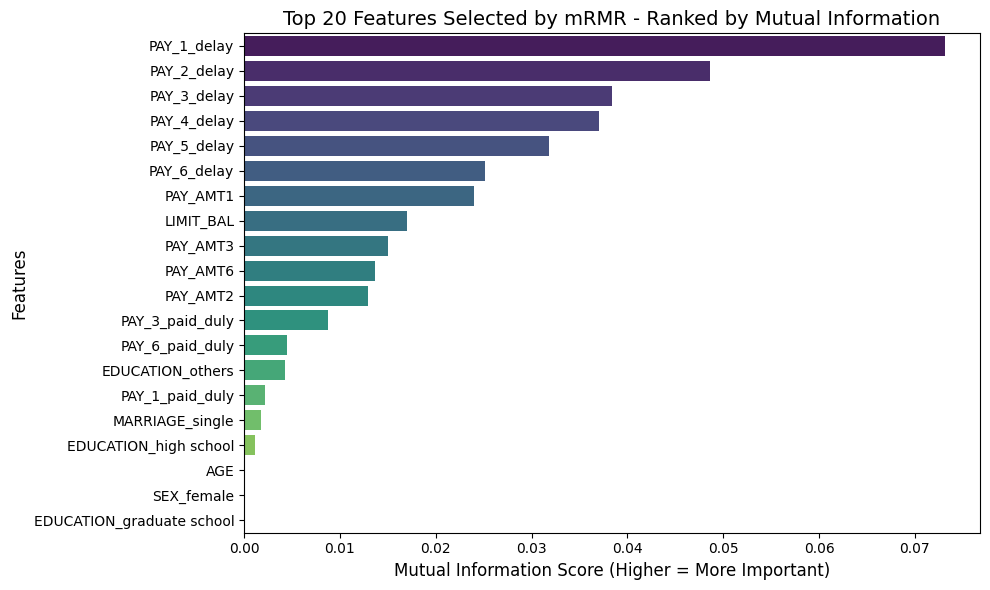

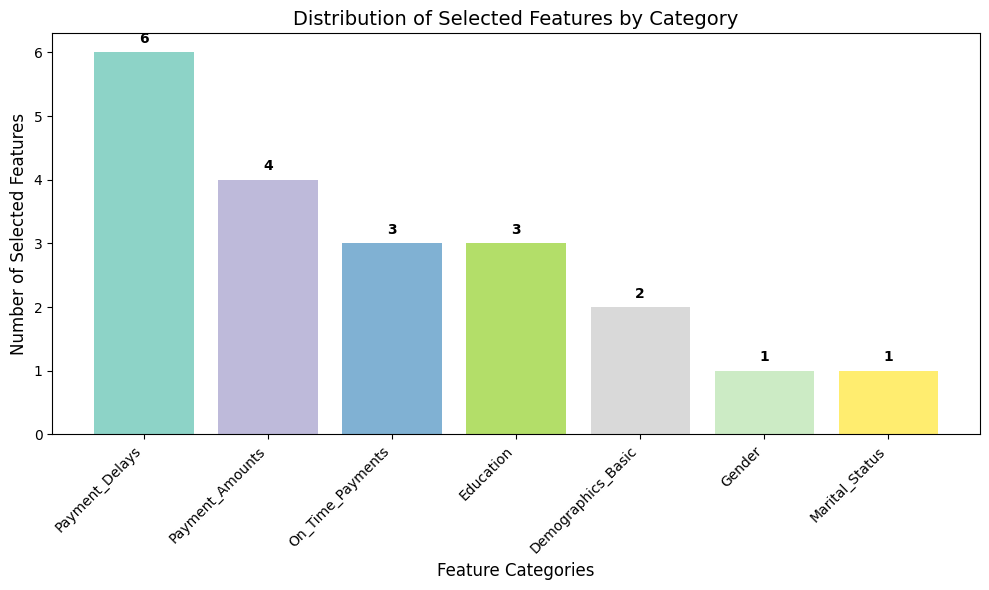


Comprehensive Feature Summary:
                  Feature           Category  Mutual_Information Feature_Type
              PAY_1_delay     Payment_Delays            0.073142     Discrete
              PAY_2_delay     Payment_Delays            0.048583     Discrete
              PAY_3_delay     Payment_Delays            0.038357     Discrete
              PAY_4_delay     Payment_Delays            0.036995     Discrete
              PAY_5_delay     Payment_Delays            0.031829     Discrete
              PAY_6_delay     Payment_Delays            0.025151     Discrete
                 PAY_AMT1    Payment_Amounts            0.023995    Numerical
                LIMIT_BAL Demographics_Basic            0.017043    Numerical
                 PAY_AMT3    Payment_Amounts            0.015071    Numerical
                 PAY_AMT6    Payment_Amounts            0.013660    Numerical
                 PAY_AMT2    Payment_Amounts            0.012973    Numerical
          PAY_3_paid_duly   On_T

In [62]:
# Display selected features with detailed information
from sklearn.feature_selection import mutual_info_classif

print("\n" + "="*80)
print("DETAILED MRMR FEATURE SELECTION RESULTS")
print("="*80)

print(f"\nDataset Summary:")
print(f"  • Total features analyzed: {X.shape[1]}")
print(f"  • Features selected by mRMR: {len(selected_features)}")
print(f"  • Reduction in dimensionality: {100 * (1 - len(selected_features) / X.shape[1]):.1f}%")

print(f"\nTop Selected Features:")
for i, feature in enumerate(selected_features):
    print(f"  {i+1:2d}. {feature}")
    
# Calculate feature importance using mutual information as an additional measure
def calculate_mutual_info(X, y, features):
    mi_scores = mutual_info_classif(X[features], y, random_state=12345)
    return dict(zip(features, mi_scores))

mi_scores = calculate_mutual_info(X, y, selected_features)
mi_df = pd.DataFrame({
    'Feature': list(mi_scores.keys()),
    'Mutual_Information': list(mi_scores.values())
}).sort_values('Mutual_Information', ascending=False)

print(f"\nFeature Importance (Mutual Information with target):")
for i, (_, row) in enumerate(mi_df.head(10).iterrows()):
    print(f"  {i+1:2d}. {row['Feature']}: {row['Mutual_Information']:.4f}")

# Visualize mutual information scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual_Information', y='Feature', data=mi_df.head(20), palette='viridis')
plt.title('Top 20 Features Selected by mRMR - Ranked by Mutual Information', fontsize=14)
plt.xlabel('Mutual Information Score (Higher = More Important)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Create feature type distribution plot
def categorize_selected_feature(feature_name):
    """Categorize selected features into meaningful groups."""
    if any(pay_col in feature_name for pay_col in ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']):
        if 'delay' in feature_name:
            return 'Payment_Delays'
        elif 'paid_duly' in feature_name:
            return 'On_Time_Payments'
        elif 'no_consumption' in feature_name:
            return 'No_Consumption'
        else:
            return 'Payment_Status'
    elif feature_name.startswith('SEX_'):
        return 'Gender'
    elif feature_name.startswith('EDUCATION_'):
        return 'Education'
    elif feature_name.startswith('MARRIAGE_'):
        return 'Marital_Status'
    elif feature_name in ['LIMIT_BAL', 'AGE']:
        return 'Demographics_Basic'
    elif feature_name.startswith('BILL_AMT'):
        return 'Bill_Amounts'
    elif feature_name.startswith('PAY_AMT'):
        return 'Payment_Amounts'
    elif feature_name == 'avg_bill':
        return 'Derived_Features'
    else:
        return 'Other'

# Create feature category analysis
feature_categories = [categorize_selected_feature(feat) for feat in selected_features]
category_counts = pd.Series(feature_categories).value_counts()

# Plot feature category distribution
plt.figure(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(category_counts)))
bars = plt.bar(range(len(category_counts)), category_counts.values, color=colors)
plt.xlabel('Feature Categories', fontsize=12)
plt.ylabel('Number of Selected Features', fontsize=12)
plt.title('Distribution of Selected Features by Category', fontsize=14)
plt.xticks(range(len(category_counts)), category_counts.index, rotation=45, ha='right')

# Add value labels on bars
for bar, val in zip(bars, category_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Create a comprehensive summary table
summary_df = pd.DataFrame({
    'Feature': selected_features,
    'Category': feature_categories,
    'Mutual_Information': [mi_scores[f] for f in selected_features],
    'Feature_Type': ['Numerical' if f in numerical_features else 'Discrete' for f in selected_features]
}).sort_values('Mutual_Information', ascending=False)

print(f"\nComprehensive Feature Summary:")
print(summary_df.to_string(index=False))